# **Amazon: Dynamic Pricing with my boy Jeffrey, 1964**

<img src="../images/NotJefferey.jpg" height=400 width=950>

## **The schema for the dataset**

### Importing the necessary libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

import os 
import warnings as warn 

sns.set_style('darkgrid')
warn.simplefilter('ignore')

### Loading all the datasets

#### Orders Datasets preprocessing. 

In [2]:
# rename for convenience 
if 'Orders.csv' not in os.listdir('../data'): 
    os.rename(
        '../data/AmazonSaleReport.csv', 
        '../data/Orders.csv'
    )

orders_path = '../data/Orders.csv'
orders = pd.read_csv(orders_path)
display(orders.head())

,Unnamed: 0,OrderID,Date,Status,Fulfilment,SalesChannel,shipservicelevel,Style,SKU,Category,...,Qty,currency,Amount,shipcity,shipstate,shippostalcode,shipcountry,promotionids,B2B,fulfilledby
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,0,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,1,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,1,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,0,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,1,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN


##### Identifying the primary key 

In [3]:
# rows in dataset 
rows = len(orders)

counts = {
    "ColumnName": [name for name in orders.columns], 
    "UniqCount": [len(orders[colname].unique()) for colname in orders.columns], 
}

uniqCount = pd.DataFrame(counts)
display(uniqCount)

,ColumnName,UniqCount
0,Unnamed: 0,128975
1,OrderID,120378
2,Date,91
3,Status,13
4,Fulfilment,2
5,SalesChannel,2
6,shipservicelevel,2
7,Style,1377
8,SKU,7195
9,Category,9


##### OrderID is approximately the key in this dataset however around 8k of order id's are repeated. 

In [4]:
if 'index' in orders.columns: orders.drop(columns=['index'], inplace=True)

# remove White spaces from column names 
mapper = {colname: colname.replace(" ", "").replace("-", "") for colname in orders.columns}
orders.rename(mapper=mapper, axis=1, inplace=True)

# Investigate repeated order id's 
repeatedIDs = orders.OrderID.value_counts().reset_index().loc[
    orders.OrderID.value_counts().reset_index()["count"] > 1, :
]

display(repeatedIDs)


,OrderID,count
0,171-5057375-2831560,12
1,403-4984515-8861958,12
2,403-0173977-3041148,11
3,404-9932919-6662730,11
4,408-3317403-1729937,10
...,...,...
6841,406-9917436-4093923,2
6842,408-4603795-6133936,2
6843,405-5072638-5053100,2
6844,407-8519205-5064368,2


In [5]:
ridData = orders[orders.OrderID.isin(repeatedIDs.OrderID)]
ridDataUniqCount = {
    "ColumnName":[colname for colname in ridData.columns], 
    "UniqueCnt":[len(ridData[colname].unique()) for colname in ridData.columns]
}

uniqRiD = pd.DataFrame(ridDataUniqCount)
uniqRiD['uniqTotalCount'] = uniqCount['UniqCount']
display(uniqRiD)

,ColumnName,UniqueCnt,uniqTotalCount
0,Unnamed:0,15443,128975
1,OrderID,6846,120378
2,Date,91,91
3,Status,10,13
4,Fulfilment,2,2
5,SalesChannel,1,2
6,shipservicelevel,2,2
7,Style,1168,1377
8,SKU,4672,7195
9,Category,9,9


#### SalesChannel is the only common theme amongst these repeated ID's but Amazon.in is the most commonly repeated values

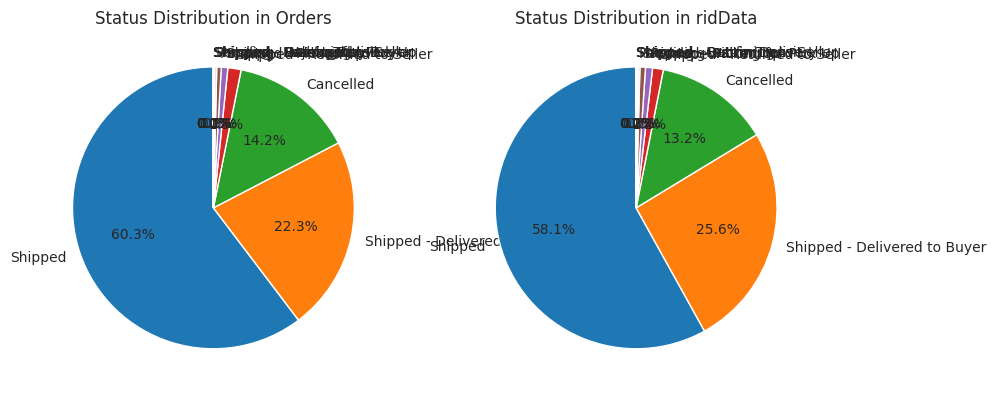

In [6]:
repId = ridData.OrderID.values.tolist()
status_counts_orders = orders['Status'].value_counts()
status_counts_ridData = ridData['Status'].value_counts()

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Pie chart for "orders"
axs[0].pie(status_counts_orders, labels=status_counts_orders.index, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Status Distribution in Orders')

# Pie chart for "ridData"
axs[1].pie(status_counts_ridData, labels=status_counts_ridData.index, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Status Distribution in ridData')

plt.show()

In [7]:
orders['Date'] = pd.to_datetime(orders.Date)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Unnamed:0         128975 non-null  int64         
 1   OrderID           128975 non-null  object        
 2   Date              128975 non-null  datetime64[ns]
 3   Status            128975 non-null  object        
 4   Fulfilment        128975 non-null  object        
 5   SalesChannel      128975 non-null  object        
 6   shipservicelevel  128975 non-null  object        
 7   Style             128975 non-null  object        
 8   SKU               128975 non-null  object        
 9   Category          128975 non-null  object        
 10  Size              128975 non-null  object        
 11  ASIN              128975 non-null  object        
 12  CourierStatus     122103 non-null  object        
 13  Qty               128975 non-null  int64         
 14  curr

#### Unnamed is a mystery column which we will save in a mystery.csv

In [9]:
if "Unnamed:22" in orders.columns: 
    mystery = orders["Unnamed:22"]
    mystery.to_csv("../data/mystery.csv")

    orders.drop(columns=['Unnamed:22'], inplace=True)
    orders.to_csv("../data/Orders.csv")

#### The International sales report csv mining 

In [13]:
intl_report = pd.read_csv("../data/InternationalsaleReport.csv").iloc[:18635, :].drop(columns=['index'])
display(intl_report)

,DATE,Months,CUSTOMER,Style,SKU,Size,PCS,RATE,GROSS AMT
0,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-L,L,1.00,616.56,617.00
1,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-XL,XL,1.00,616.56,617.00
2,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-XXL,XXL,1.00,616.56,617.00
3,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5009,MEN5009-KR-L,L,1.00,616.56,617.00
4,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5011,MEN5011-KR-L,L,1.00,616.56,617.00
...,...,...,...,...,...,...,...,...,...
18630,04-30-22,Apr-22,Rino Sandaran,J0280,NaN,S,1.00,1812.50,1812.50
18631,04-30-22,Apr-22,Rino Sandaran,SET350,NaN,M,1.00,1512.50,1512.50
18632,04-30-22,Apr-22,Rino Sandaran,SET350,NaN,L,1.00,1512.50,1512.50
18633,04-30-22,Apr-22,Rino Sandaran,J0242,NaN,XXXL,1.00,1312.50,1312.50


In [29]:
stylestock = pd.read_csv("../data/InternationalsaleReport.csv", header=18661)[:19675-18661].drop(columns=["18660"] + [f"Unnamed: {i}" for i in range(3, 10)])
stylestock.to_csv("../data/stylestock.csv")

In [45]:
intl_report = pd.merge(intl_report, stylestock, how = 'inner', on='Style')
intl_report['SKU'] = intl_report.apply(lambda df: df.Style + '-KR-'+ df.Size, axis=1) 

In [48]:
intl_report_contd = pd.read_csv("../data/InternationalsaleReport.csv", header=19676).drop(columns=["19675"])
intl_report_contd[["DATE", "Months", "CUSTOMER", "Style", "SKU","PCS", "RATE", "GROSS AMT"]]

stock = pd.concat([intl_report.drop(columns=["Size"]), intl_report_contd]).drop(columns=["Stock_x", "Stock_y"])

In [38]:
intl_report_contd

,CUSTOMER,DATE,Months,Style,SKU,PCS,RATE,GROSS AMT,Stock
0,REVATHY LOGANATHAN,06-05-21,Jun-21,MEN5004,MEN5004-KR-L,1.0,616.56,617.0,8.0
1,REVATHY LOGANATHAN,06-05-21,Jun-21,MEN5004,MEN5004-KR-XL,1.0,616.56,617.0,4.0
2,REVATHY LOGANATHAN,06-05-21,Jun-21,MEN5004,MEN5004-KR-XXL,1.0,616.56,617.0,6.0
3,REVATHY LOGANATHAN,06-05-21,Jun-21,MEN5009,MEN5009-KR-L,1.0,616.56,617.0,6.0
4,REVATHY LOGANATHAN,06-05-21,Jun-21,MEN5011,MEN5011-KR-L,1.0,616.56,617.0,11.0
...,...,...,...,...,...,...,...,...,...
17751,AVIN,03-31-22,Mar-22,PJNE3423,PJNE3423-KR-4XL,1.0,537.50,538.0,4.0
17752,AVIN,03-31-22,Mar-22,PJNE3404,PJNE3404-KR-4XL,1.0,500.00,500.0,5.0
17753,AVIN,03-31-22,Mar-22,PJNE3423,PJNE3423-KR-4XL,1.0,537.50,538.0,4.0
17754,AVIN,03-31-22,Mar-22,SET290,SET290-KR-DPT-M,1.0,812.50,812.0,7.0


In [41]:
stylestock

,Style,Stock
0,MEN5004,43.00
1,MEN5009,55.00
2,MEN5011,53.00
3,MEN5025,34.00
4,MEN5015,119.00
...,...,...
1009,J0419,313.00
1010,JNE3905,299.00
1011,JAN8623,0.00
1012,J0391,270.00


In [49]:
stock.to_csv("../data/stonks.csv")

#### May 2022 and PL March 2021

In [57]:
may = pd.read_csv("../data/May-2022.csv")
march = pd.read_csv("../data/PLMarch2021.csv")

may['mon-year'] = 'May-22'
march['mon-year'] = 'Mar-21'

march = march.drop(columns=['TP 2']).rename({"TP 1":"TP"}, axis=1)

pd.concat([may, march]).to_csv("../db/AllEcommerce.csv")



#### Sales report 

In [78]:
salesreport = pd.read_csv("../data/SaleReport.csv").drop(columns=["index"])
salesreport.to_csv("../db/salesreport.csv")

In [60]:
orders

,Unnamed:0,OrderID,Date,Status,Fulfilment,SalesChannel,shipservicelevel,Style,SKU,Category,...,Qty,currency,Amount,shipcity,shipstate,shippostalcode,shipcountry,promotionids,B2B,fulfilledby
0,0,405-8078784-5731545,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,0,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship
1,1,171-9198151-1101146,2022-04-30,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,1,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship
2,2,404-0687676-7273146,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,1,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN
3,3,403-9615377-8133951,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,0,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship
4,4,407-1069790-7240320,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,1,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128970,128970,406-6001380-7673107,2022-05-31,Shipped,Amazon,Amazon.in,Expedited,JNE3697,JNE3697-KR-XL,kurta,...,1,INR,517.00,HYDERABAD,TELANGANA,500013.0,IN,NaN,False,NaN
128971,128971,402-9551604-7544318,2022-05-31,Shipped,Amazon,Amazon.in,Expedited,SET401,SET401-KR-NP-M,Set,...,1,INR,999.00,GURUGRAM,HARYANA,122004.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,False,NaN
128972,128972,407-9547469-3152358,2022-05-31,Shipped,Amazon,Amazon.in,Expedited,J0157,J0157-DR-XXL,Western Dress,...,1,INR,690.00,HYDERABAD,TELANGANA,500049.0,IN,NaN,False,NaN
128973,128973,402-6184140-0545956,2022-05-31,Shipped,Amazon,Amazon.in,Expedited,J0012,J0012-SKD-XS,Set,...,1,INR,1199.00,Halol,Gujarat,389350.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,False,NaN


In [82]:

codes = salesreport["SKU Code"].value_counts().reset_index()[
    salesreport["SKU Code"].value_counts().reset_index()["count"] > 1
]["SKU Code"].values

salesreport.drop(
    salesreport[salesreport["SKU Code"].isin(codes)].index, 
    inplace=True, 
)

mapper = {
    colname : colname.replace(" ", "") for colname in salesreport.columns 
}

salesreport.rename(mapper, axis=1, inplace=True)
display(salesreport)

,SKUCode,DesignNo.,Stock,Category,Size,Color
0,AN201-RED-L,AN201,5.0,AN : LEGGINGS,L,Red
1,AN201-RED-M,AN201,5.0,AN : LEGGINGS,M,Red
2,AN201-RED-S,AN201,3.0,AN : LEGGINGS,S,Red
3,AN201-RED-XL,AN201,6.0,AN : LEGGINGS,XL,Red
4,AN201-RED-XXL,AN201,3.0,AN : LEGGINGS,XXL,Red
...,...,...,...,...,...,...
9230,SET462-KR-NP-S,SET462,44.0,SET,S,Teal
9231,SET462-KR-NP-XL,SET462,58.0,SET,XL,Teal
9232,SET462-KR-NP-XS,SET462,20.0,SET,XS,Teal
9233,SET462-KR-NP-XXL,SET462,66.0,SET,XXL,Teal


In [91]:
salesreport.to_csv("../db/salesreport.csv")

In [81]:
salesreport["SKU Code"].isin(codes)

RangeIndex(start=0, stop=9235, step=1)

In [90]:
orders.Qty.value_counts().reset_index()

,Qty,count
0,1,115780
1,0,12807
2,2,341
3,3,32
4,4,9
5,5,2
6,15,1
7,9,1
8,13,1
9,8,1
